# Monocle3 on Colab


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnTigue/colab-ing/blob/master/probings/monocle3_on_colab_probings.ipynb)

This notebook simple tests to see if [Monocle3](https://cole-trapnell-lab.github.io/monocle3/) can be deployed and exercised on Colab. It can.

## R on Colab
Monocle3, "an analysis toolkit for single-cell RNA-seq," is written in R. Turns out Colab can run R notebooks.

On 2019-06-18 JFT found IRkernel's Demo.html via [stackoverflow: How to use R with Google Colaboratory?](https://stackoverflow.com/a/54595286). I.e starting from a demo page ([Demo.ipynb](https://github.com/IRkernel/IRkernel/blob/master/example-notebooks/Demo.ipynb)) of IRkernel which is [MIT licensed](https://github.com/IRkernel/IRkernel/blob/master/DESCRIPTION#L20) this page was built out on Colab. 

The core point is to start with Demo.ipynb because is has the JSON metadata to specify that the notebook is designed for an R kernel, and Colab will provide:
```
{
  "nbformat": 4,
  "nbformat_minor": 0,
  "metadata": {
    "language_info": {
      "codemirror_mode": "r",
      "file_extension": ".r",
      "mimetype": "text/x-r-source",
      "name": "R",
      "pygments_lexer": "r",
      "version": "3.3.1"
    },
    "kernelspec": {
      "display_name": "R",
      "language": "R",
      "name": "ir"
    }
  }...
```


## Monocle3 install on Colab

The Monocle folks did nice work making it [easy to install Monocle3](https://cole-trapnell-lab.github.io/monocle3/monocle3_docs/#installing-monocle-3). Nonetheless, the following needs to happen before installing Monocle, otherwise various support libraries (e.g. units) will fail to install.

While hacking to get Monocle3 running on Colab, various dependency libraries to not install without a fight. Again, hacking I found [others with similar issues](https://github.com/datacarpentry/r-raster-vector-geospatial/issues/138#issue-313014296) and the solution seems to be:
```
!apt-get -qq install -y libudunits2-dev libgdal-dev libgeos-dev libproj-dev 
```
But unfortuneately, IRkernel does not seem to handle !magics so `apt-get has to be evoked via an R system() call.

In [ ]:
# via https://github.com/datacarpentry/r-raster-vector-geospatial/issues/138#issue-313014296
system("apt-get -qq install -y libudunits2-dev libgdal-dev libgeos-dev libproj-dev", intern=TRUE)


character(0)

The stock install instructions begin with installing Bioconductor.

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install()


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.12 (BiocManager 1.30.12), R 4.0.5 (2021-03-31)

Installing package(s) 'BiocVersion'

Old packages: 'dbplyr', 'devtools', 'pkgload'



In [ ]:
BiocManager::install("rhdf5")

In [5]:
library("rhdf5")    # can be installed using Bioconductor

destination_file = "human_matrix_v9.h5"
extracted_expression_file = "GSE113581_expression_matrix.tsv"
url = "https://s3.amazonaws.com/mssm-seq-matrix/human_matrix_v9.h5"

# Check if gene expression file was already downloaded, if not in current directory download file form repository
if(!file.exists(destination_file)){
    print("Downloading compressed gene expression matrix.")
    download.file(url, destination_file, quiet = FALSE, mode = 'wb')
}

# Selected samples to be extracted
samp = c("GSM3109276","GSM3109277","GSM3109278","GSM3109279","GSM3109280","GSM3109281","GSM3109282","GSM3109283","GSM3109284","GSM3109285","GSM3109286","GSM3109287","GSM3109288","GSM3109289","GSM3109290","GSM3109276","GSM3109277","GSM3109278","GSM3109279","GSM3109280","GSM3109281","GSM3109282","GSM3109283","GSM3109284","GSM3109285","GSM3109286","GSM3109287","GSM3109288","GSM3109289","GSM3109290","")

# Retrieve information from compressed data
samples = h5read(destination_file, "meta/samples/geo_accession")
genes = h5read(destination_file, "meta/genes/genes")

# Identify columns to be extracted
sample_locations = which(samples %in% samp)

# extract gene expression from compressed data
expression = t(h5read(destination_file, "data/expression", index=list(sample_locations, 1:length(genes))))
H5close()
rownames(expression) = genes
colnames(expression) = samples[sample_locations]

# Print file
write.table(expression, file=extracted_expression_file, sep="\t", quote=FALSE, col.names=NA)
print(paste0("Expression file was created at ", getwd(), "/", extracted_expression_file))



ERROR: ignored

In [9]:
download.file(url, destination_file, quiet = FALSE, mode = 'wb')

Warning message in download.file(url, destination_file, quiet = FALSE, mode = "wb"):
“downloaded length 3321872621 != reported length 12198788988”
Warning message in download.file(url, destination_file, quiet = FALSE, mode = "wb"):
“URL 'https://s3.amazonaws.com/mssm-seq-matrix/human_matrix_v9.h5': Timeout of 60 seconds was reached”


ERROR: ignored

The second step in the stock install instructions is to actually install Monocle3. For whatever reason, Bioconductor needs to be explicitly told to install 8 packages that are needed.

In [ ]:
# Issue, devtools::install_github('cole-trapnell-lab/monocle3') will report:
#   Skipping 8 packages not available: Biobase, BiocGenerics, DelayedArray, DelayedMatrixStats, limma, S4Vectors, SingleCellExperiment, SummarizedExperiment
# So, explicitly installing these seemed to help:
BiocManager::install("Biobase")
BiocManager::install("DelayedArray")
BiocManager::install("DelayedMatrixStats")
BiocManager::install("limma")
BiocManager::install("S4Vectors")
BiocManager::install("SingleCellExperiment")
BiocManager::install("SummarizedExperiment")


Bioconductor version 3.9 (BiocManager 1.30.4), R 3.6.0 (2019-04-26)
Installing package(s) 'Biobase'
also installing the dependency ‘BiocGenerics’

Update old packages: 'askpass', 'assertthat', 'backports', 'base64enc', 'BH',
  'broom', 'callr', 'cellranger', 'cli', 'clipr', 'clisymbols', 'colorspace',
  'crayon', 'curl', 'DBI', 'dbplyr', 'desc', 'devtools', 'ellipsis',
  'evaluate', 'fansi', 'forcats', 'gdtools', 'generics', 'ggplot2', 'gh',
  'git2r', 'glue', 'gtable', 'haven', 'highr', 'hms', 'htmltools', 'httr',
  'ini', 'jsonlite', 'labeling', 'lazyeval', 'littler', 'lubridate',
  'magrittr', 'markdown', 'memoise', 'mime', 'modelr', 'munsell', 'openssl',
  'pillar', 'pkgbuild', 'pkgconfig', 'pkgKitten', 'pkgload', 'plogr', 'plyr',
  'prettyunits', 'ps', 'purrr', 'R6', 'RColorBrewer', 'Rcpp', 'readr',
  'readxl', 'rematch', 'remotes', 'reshape2', 'rlang', 'rprojroot',
  'rstudioapi', 'scales', 'selectr', 'sessioninfo', 'stringi', 'stringr',
  'tibble', 'tidyr', 'tidyselect', 'tidyve

Back to stock install step 2:

In [ ]:
devtools::install_github('cole-trapnell-lab/monocle3')


crosstalk (NA -> 1.0.0) [CRAN]
plotly    (NA -> 4.9.0) [CRAN]
sf        (NA -> 0.7-4) [CRAN]
shiny     (NA -> 1.3.2) [CRAN]
spdep     (NA -> 1.1-2) [CRAN]
uwot      (NA -> 0.1.3) [CRAN]
viridis   (NA -> 0.5.1) [CRAN]


Skipping 8 packages not available: Biobase, BiocGenerics, DelayedArray, DelayedMatrixStats, limma, S4Vectors, SingleCellExperiment, SummarizedExperiment
Installing 7 packages: crosstalk, plotly, sf, shiny, spdep, uwot, viridis
Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


✔  checking for file ‘/tmp/RtmpNBzKfa/remotes98e780ac4f7/cole-trapnell-lab-monocle3-7427951/DESCRIPTION’
─  preparing ‘monocle3’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘monocle3_0.1.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


In [ ]:
# The following is the recommended way to test an install of Monocle3:
library(monocle3)

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with


And that's it. Their set up is simple. Bit slow on Colab but c'est la vie. With more hacking experience I'm sure we can somehow streamline this (I'm an R noob).



# Exercising Monocle3 on Colab

Hannah Pliner, one of [the two devs of Monocle3](https://github.com/cole-trapnell-lab/monocle3/graphs/contributors), gave presentations on Monocle3 at [Brotman Baty Institute's Single Cell Symposium](https://brotmanbaty.org/event/single-cell-symposium/). Her [tutorial content](http://staff.washington.edu/hpliner/) is on-line, which includes some test data and [an R script for doing the basics with Monocle3](http://staff.washington.edu/hpliner/scripts/20190603_tutorial_script.R). The data is from C. elegans data from [Cao & Packer et al. 2017](https://science.sciencemag.org/content/357/6352/661) as explained in [the Monocle3 docs](https://cole-trapnell-lab.github.io/monocle3/monocle3_docs/#clustering-and-classifying-your-cells).

Here, Pliner's script is copied with minimal modification to get things going on Colab, including breaking it out into multiple code cells.

In [ ]:
# Load up Pliner's test data
expression_matrix <- readRDS(url("http://staff.washington.edu/hpliner/data/cao_l2_expression.rds"))
cell_metadata <- readRDS(url("http://staff.washington.edu/hpliner/data/cao_l2_colData.rds"))
gene_annotation <- readRDS(url("http://staff.washington.edu/hpliner/data/cao_l2_rowData.rds"))

cds <- new_cell_data_set(expression_matrix,
                         cell_metadata = cell_metadata,
                         gene_metadata = gene_annotation)

In [ ]:
# Test out the accessor functions:
colData(cds)

rowData(cds)

head(counts(cds))



DataFrame with 42035 rows and 5 columns
                           plate cao_cluster            cao_cell_type
                        <factor>    <factor>              <character>
cele-001-001.CATGACTCAA      001          20     Unclassified neurons
cele-001-001.AAGACGGCCA      001           6                 Germline
cele-001-001.GCCAACGCCA      001          13 Intestinal/rectal muscle
cele-001-001.ATAGGAGTAC      001          27        Vulval precursors
cele-001-001.CTCGTCTAGG      001           2             Coelomocytes
...                          ...         ...                      ...
cele-010-092.CGTATTGAGA      010          17                       NA
cele-010-092.AGGTCTATGG      010          27        Vulval precursors
cele-010-092.TGCGAAGATC      010           9         Body wall muscle
cele-010-092.GTATTAAGTT      010          26                Failed QC
cele-010-092.GAAGTCCGTC      010          16        GABAergic neurons
                                      cao_tissue  

DataFrame with 20271 rows and 1 column
               gene_short_name
                      <factor>
WBGene00000001           aap-1
WBGene00000002           aat-1
WBGene00000003           aat-2
WBGene00000004           aat-3
WBGene00000005           aat-4
...                        ...
WBGene00269389        C08F1.12
WBGene00269391        F54F2.14
WBGene00269392        F54F7.14
WBGene00269394        F59H6.15
WBGene00269421        R06F6.14

   [[ suppressing 34 column names ‘cele-001-001.CATGACTCAA’, ‘cele-001-001.AAGACGGCCA’, ‘cele-001-001.GCCAACGCCA’ ... ]]


6 x 42035 sparse Matrix of class "dgCMatrix"
                                                                              
WBGene00000001 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
WBGene00000002 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
WBGene00000003 . . . . . . . . . . . . . . . . . . . . . . . . . . . . 2 . . .
WBGene00000004 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
WBGene00000005 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
WBGene00000006 . . . . . . 1 . . . . . . . . . . . . . . . . . 2 . . . . . . .
                         
WBGene00000001 . . ......
WBGene00000002 . . ......
WBGene00000003 . . ......
WBGene00000004 . . ......
WBGene00000005 . . ......
WBGene00000006 . . ......

 .....suppressing 42001 columns in show(); maybe adjust 'options(max.print= *, width = *)'
 ..............................

No trajectory to plot. Has learn_graph() been called yet?
cluster not found in colData(cds), cells will not be colored
cluster_cells() has not been called yet, can't color cells by cluster


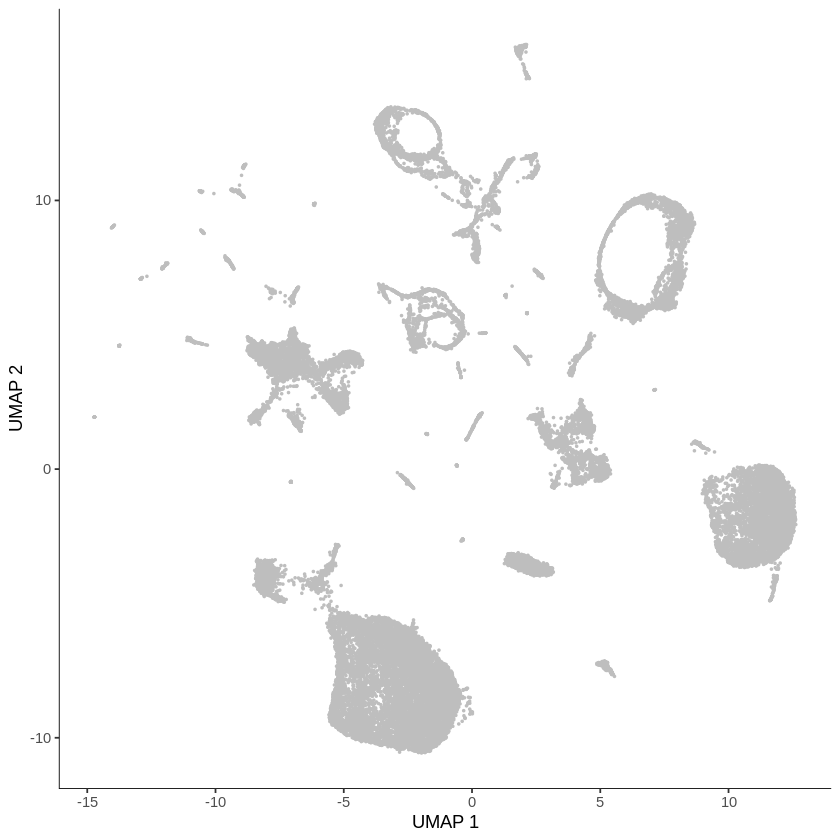

In [ ]:
# Preprocess the cds - in default mode, this function normalizes the
# data and runs PCA
cds <- preprocess_cds(cds, num_dim = 100)

# Run UMAP to get a low dimension representation, and plot
cds <- reduce_dimension(cds)
plot_cells(cds)



cele-001-001.CATGACTCAA cele-001-001.AAGACGGCCA cele-001-001.GCCAACGCCA 
                     27                      23                      20 
cele-001-001.ATAGGAGTAC cele-001-001.CTCGTCTAGG cele-001-001.AAGTTGCCAT 
                     19                      34                      23 
40 Levels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 40

cele-001-001.CATGACTCAA cele-001-001.AAGACGGCCA cele-001-001.GCCAACGCCA 
                     43                      46                      23 
cele-001-001.ATAGGAGTAC cele-001-001.CTCGTCTAGG cele-001-001.AAGTTGCCAT 
                     76                      78                      33 
92 Levels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 92

No trajectory to plot. Has learn_graph() been called yet?
Adding missing grouping variables: `cell_group`, `cell_color`
Joining, by = c("cell_group", "cell_color")
No trajectory to plot. Has learn_graph() been called yet?
Adding missing grouping variables: `cell_group`, `cell_color`
Joining, by = c("cell_group", "cell_color")


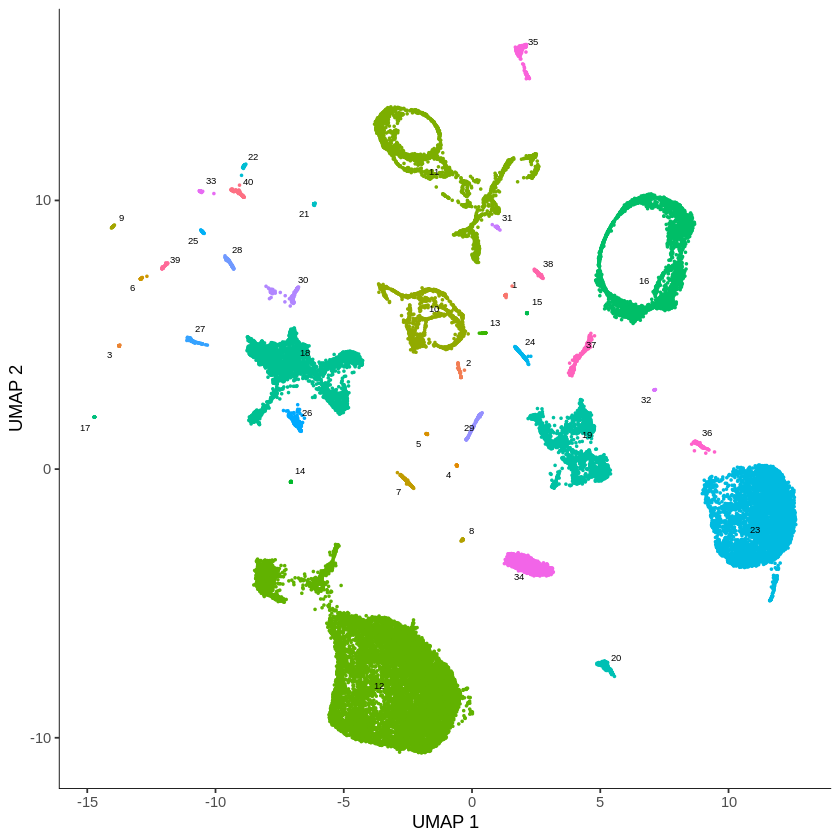

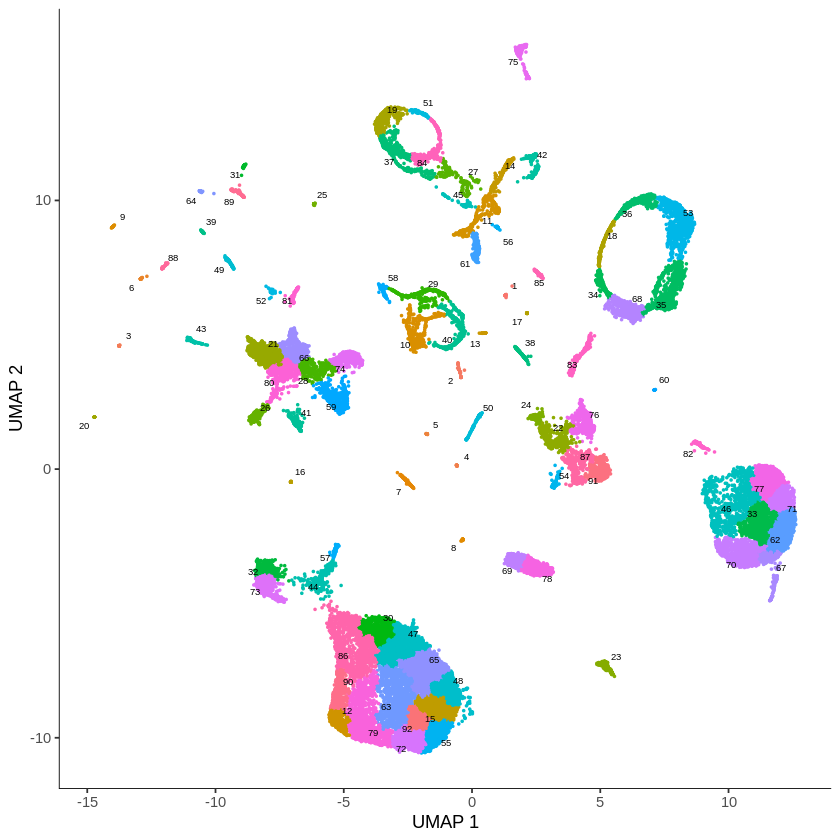

In [ ]:
# Cluster cells and view the clusters and partitions (super-clusters)
cds <- cluster_cells(cds)
head(partitions(cds, reduction_method = "UMAP"))
head(clusters(cds, reduction_method = "UMAP"))

plot_cells(cds, color_cells_by="partition", group_cells_by="partition")
plot_cells(cds, color_cells_by="cluster", group_cells_by="cluster")



In [ ]:
# Subset cells interactively
cds_subset <- choose_cells(cds)

# The above line will generate the following error:
#   Error: choose_cells only works in interactive mode.
# I guess that the script was build for RStudio or such, not for Jupyter widgetery.

ERROR: ignored

In [ ]:
# JFT: these next 8 lines were not tested. They are from Pliner's script but
# since cds_subset did NOT just get set above, the party is over.

# Compare genes across chosen clusters (first 100 genes for speed)
gene_fits <- fit_models(cds_subset[1:100,], model_formula_str = "~cluster")
fit_coefs <- coefficient_table(gene_fits)
head(fit_coefs)

# Find top marker genes for each cluster
marker_genes <- top_markers(cds[1:1000,], genes_to_test_per_group = 3)
head(marker_genes)

tops_sig <- subset(marker_genes, marker_test_q_value < .05)

plot_cells(cds_subset, genes=gene_cluster_df, show_trajectory_graph=F, color_by="cell.type")


generate_garnett_marker_file(marker_genes)


DataFrame with 42035 rows and 5 columns
                           plate cao_cluster            cao_cell_type
                        <factor>    <factor>              <character>
cele-001-001.CATGACTCAA      001          20     Unclassified neurons
cele-001-001.AAGACGGCCA      001           6                 Germline
cele-001-001.GCCAACGCCA      001          13 Intestinal/rectal muscle
cele-001-001.ATAGGAGTAC      001          27        Vulval precursors
cele-001-001.CTCGTCTAGG      001           2             Coelomocytes
...                          ...         ...                      ...
cele-010-092.CGTATTGAGA      010          17                       NA
cele-010-092.AGGTCTATGG      010          27        Vulval precursors
cele-010-092.TGCGAAGATC      010           9         Body wall muscle
cele-010-092.GTATTAAGTT      010          26                Failed QC
cele-010-092.GAAGTCCGTC      010          16        GABAergic neurons
                                      cao_tissue  

DataFrame with 20271 rows and 1 column
               gene_short_name
                      <factor>
WBGene00000001           aap-1
WBGene00000002           aat-1
WBGene00000003           aat-2
WBGene00000004           aat-3
WBGene00000005           aat-4
...                        ...
WBGene00269389        C08F1.12
WBGene00269391        F54F2.14
WBGene00269392        F54F7.14
WBGene00269394        F59H6.15
WBGene00269421        R06F6.14

   [[ suppressing 34 column names ‘cele-001-001.CATGACTCAA’, ‘cele-001-001.AAGACGGCCA’, ‘cele-001-001.GCCAACGCCA’ ... ]]


6 x 42035 sparse Matrix of class "dgCMatrix"
                                                                              
WBGene00000001 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
WBGene00000002 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
WBGene00000003 . . . . . . . . . . . . . . . . . . . . . . . . . . . . 2 . . .
WBGene00000004 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
WBGene00000005 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
WBGene00000006 . . . . . . 1 . . . . . . . . . . . . . . . . . 2 . . . . . . .
                         
WBGene00000001 . . ......
WBGene00000002 . . ......
WBGene00000003 . . ......
WBGene00000004 . . ......
WBGene00000005 . . ......
WBGene00000006 . . ......

 .....suppressing 42001 columns in show(); maybe adjust 'options(max.print= *, width = *)'
 ..............................

## Next

OK stopping here, the goal was to see if Monocle3 can be deployed on Colab. Mostly, yes.

Next step would seem to be actually use Monocle on data from the wild, rather than prepackaged test data in *.rds files.